# MicroCause

In [1]:
%reload_ext autoreload
%autoreload 2

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

from ads_evt import dSPOT
import tigramite.data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI
from tigramite.independence_tests.parcorr import ParCorr
from pingouin import partial_corr

In [3]:
import sys
sys.path.append('../')

from tsdr import tsdr
from eval import groundtruth
from meltria import loader
from eval import validation

In [9]:
SOCKSHOP_DATASET_ID = "9n6mf"

from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    SOCKSHOP_DATASET_ID, {
        "services": True,
        "containers": True,
        "middlewares": False,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": True,
        "enable_multireducer": True,
        "step1_method_name": "residual_integral",
        "step1_residual_integral_threshold": 20,
        "step1_residual_integral_change_start_point": False,
        "step1_residual_integral_change_start_point_n_sigma": 3,
        "step2_dbscan_min_pts": 1,
        "step2_dbscan_dist_type": "pearsonr",  # 'pearsonr' or 'sbd'
        "step2_dbscan_algorithm": "dbscan",  # 'dbscan' or 'hdbscan'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": "medoid",  # 'medoid' or 'maxsum'
    },
    use_manually_selected_metrics=True,
) 

In [19]:
record_1, data_df_by_metric_type_1 = dataset_by_chaos[("pod-memory-hog", "user")][1]
dataset_1 = pd.concat([
    data_df_by_metric_type_1["containers"][-1],
    data_df_by_metric_type_1["services"][-1],
], axis=1)

In [47]:
def run_SPOT(data_df: pd.DataFrame, q=1e-3, d=100, n_init=None):
    result_dict = {}
    if n_init is None:
        n_init = int(0.5 * data_df.shape[0])
    for metric_name in data_df.columns:
        x = data_df[metric_name].to_numpy()
        init_data = x[:n_init] 	# initial batch
        _data = x[n_init]  		# stream
        # q: risk parameter
        # d: depth parameter
        s = dSPOT(q=q, depth=d)     	# DSPOT object
        s.fit(init_data, _data) 	# data import
        s.initialize() 	  		# initialization step
        results = s.run()    	# run
    #     s.plot(results) 	 	# plot
        result_dict[metric_name] = results
    return result_dict

def get_eta(data_df: pd.DataFrame, SPOT_res, n_init):
    eta = np.zeros([len(data_df.columns)])
    ab_timepoint = [0 for i in range(len(data_df.columns))]
    for metric_name in data_df.columns:
        mask = data_df[metric_name][n_init:] > np.array(SPOT_res[metric_name]['thresholds'])
        ratio = np.abs(data_df[metric_name][n_init:] - np.array(SPOT_res[metric_name]['thresholds'])) / np.array(SPOT_res[metric_name]['thresholds'])
        if mask.nonzero()[0].shape[0] > 0:
            eta[metric_name] = np.max(ratio[mask.nonzero()[0]])
            ab_timepoint[metric_name] = np.min(mask.nonzero()[0])
        else:
            eta[metric_name] = 0
    return eta, ab_timepoint

In [48]:
def run_pcmci(data_df: pd.DataFrame, pc_alpha = 0.1, tau_max = 4, verbosity=0):
    pp_frame = pp.DataFrame(data=data_df.values, var_names=data_df.columns)
    cond_ind_test = ParCorr()
    pcmci = PCMCI(dataframe=pp_frame, cond_ind_test=cond_ind_test, verbosity=verbosity)
    pcmci_res = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=pc_alpha)
    return pcmci, pcmci_res

def run_lpcmci(data_df: pd.DataFrame, pc_alpha = 0.1, tau_max = 4, verbosity=0):
    pp_frame = pp.DataFrame(data=data_df.values, var_names=data_df.columns)
    cond_ind_test = ParCorr()
    lpcmci = LPCMCI(dataframe=pp_frame, cond_ind_test=cond_ind_test, verbosity=verbosity)
    lpcmci_res = lpcmci.run_lpcmci(tau_max=tau_max, pc_alpha=pc_alpha)
    return lpcmci, lpcmci_res

def get_links(data_df: pd.DataFrame, pcmci, results, alpha_level = 0.01) -> nx.DiGraph:
    pcmci_links = pcmci.return_parents_dict(results['graph'], results['val_matrix'])
    g = nx.DiGraph()
    mapping = {}
    for i in range(len(data_df.columns)):
        mapping[i] = data_df.columns[i]
        g.add_node(data_df.columns[i])
    for n, links in pcmci_links.items():
        for l in links:
            g.add_edge(mapping[n], mapping[l[0]])
    return g

In [44]:
frontend_sli_metric = "s-front-end_throughput"

def get_Q_matrix(g: nx.DiGraph, data_df: pd.DataFrame, rho: float = 0.2) -> np.ndarray:
    corr = np.corrcoef(data_df.values.T)
    for i in range(corr.shape[0]):
        corr[i, i] = 0.0
    corr = np.abs(corr)

    frontend = data_df.columns.tolist().index(frontend_sli_metric)
    
    Q = np.zeros([len(data_df.columns), len(data_df.columns)])
    for e in g.edges():
        Q[e[0], e[1]] = corr[frontend, e[1]]
        backward_e = (e[1], e[0])
        if backward_e not in g.edges():
            Q[e[1], e[0]] = rho * corr[frontend, e[0]]
            
    adj = nx.adj_matrix(g).todense()
    for i in range(0, data_df.shape[1]):
        P_pc_max = None
        res_l = np.array([corr[frontend, k] for k in adj[:, i]])
        if corr[frontend, i] > np.max(res_l):
            Q[i, i] = corr[frontend, i] - np.max(res_l)
        else:
            Q[i, i] = 0
    l = []
    for i in np.sum(Q, axis=1):
        if i > 0:
            l.append(1.0/i)
        else:
            l.append(0.0)
    l = np.diag(l)
    Q = np.dot(l, Q)
    return Q

In [51]:
def get_Q_matrix_part_corr(g: nx.DiGraph, data_df: pd.DataFrame, rho: float = 0.2):
    def get_part_corr(x, y):
        cond = get_confounders(y)
        if x in cond:
            cond.remove(x)
        if y in cond:
            cond.remove(y)
        ret = partial_corr(
            data=data_df, 
            x=data_df.columns[x], y=data_df.columns[y], covar=[data_df.columns[_] for _ in cond], 
            method='pearson',
        )
        # For a valid transition probability, use absolute correlation values.
        return abs(float(ret.r))
    
    frontend = data_df.columns.tolist().index(frontend_sli_metric)
    
    # Calculate the parent nodes set.
    pa_set = {}
    for e in g.edges():
        # Skip self links.
        if e[0] == e[1]:
            continue
        if e[1] not in pa_set:
            pa_set[e[1]] = set([e[0]])
        else:
            pa_set[e[1]].add(e[0])
    # Set an empty set for the nodes without parent nodes.
    for n in g.nodes():
        if n not in pa_set:
            pa_set[n] = set([])
            
    def get_confounders(j: int):
        ret = pa_set[frontend].difference([j])
        ret = ret.union(pa_set[j])
        return ret

    Q = np.zeros([len(data_df.columns), len(data_df.columns)])
    for e in g.edges():
        # Do not add self links.
        if e[0] == e[1]:
            continue
        # e[0] --> e[1]: cause --> result
        # Forward step. 
        # Note for partial correlation, the two variables cannot be the same.
        if frontend != e[0]:
            Q[e[1], e[0]] = get_part_corr(frontend, e[0])
        # Backward step
        backward_e = (e[1], e[0])
        # Note for partial correlation, the two variables cannot be the same.
        if backward_e not in g.edges() and frontend != e[1]:
            Q[e[0], e[1]] = rho * get_part_corr(frontend, e[1])

    adj = nx.adj_matrix(g).todense()
    for i in range(data_df.shape[1]):
        # Calculate P_pc^max
        P_pc_max = []
        # (k, i) in edges.
        for k in adj[:, i].nonzero()[0]:
            # Note for partial correlation, the two variables cannot be the same.
            if frontend != k:
                P_pc_max.append(get_part_corr(frontend, k))
        if len(P_pc_max) > 0:
            P_pc_max = np.max(P_pc_max)
        else:
            P_pc_max = 0

        # Note for partial correlation, the two variables cannot be the same.
        if frontend != i:
            q_ii = get_part_corr(frontend, i)
            if q_ii > P_pc_max:
                Q[i, i] = q_ii - P_pc_max
            else:
                Q[i, i] = 0

    l = []
    for i in np.sum(Q, axis=1):
        if i > 0:
            l.append(1.0/i)
        else:
            l.append(0.0)
    l = np.diag(l)
    Q = np.dot(l, Q)
    return Q

In [16]:
def randomwalk(
    P,
    epochs,
    start_node,
    teleportation_prob,
    walk_step=50,
    print_trace=False,
):
    n = P.shape[0]
    score = np.zeros([n])
    current = start_node - 1
    for epoch in range(epochs):
        current = start_node - 1
        if print_trace:
            print("\n{:2d}".format(current + 1), end="->")
        for step in range(walk_step):
            if np.sum(P[current]) == 0:
                break
            else:
                next_node = np.random.choice(range(n), p=P[current])
                if print_trace:
                    print("{:2d}".format(current + 1), end="->")
                score[next_node] += 1
                current = next_node
    label = [i for i in range(n)]
    score_list = list(zip(label, score))
    score_list.sort(key=lambda x: x[1], reverse=True)
    return score_list

In [17]:
def get_gamma(data_df: pd.DataFrame, score_list: list, eta: list[float], lambda_param=0.8) -> list[float]:
    gamma = [.0 for _ in range(data_df.shape[1])]
    max_vis_time = np.max([i[1] for i in score_list])
#     max_vis_time = 1.0
    max_eta = np.max(eta)
    for n,vis in score_list:
        gamma[n] = lambda_param * vis / max_vis_time + (1-lambda_param) * eta[n] / max_eta
    return gamma

In [18]:
from tabulate import tabulate

def prCal(scoreList, prk, rightOne):
    """ 
    Params:
        scoreList: list of tuple (node, score)
        prk: the top n nodes to consider
        rightOne: ground truth nodes
    """
    prkSum = 0
    for k in range(min(prk, len(scoreList))):
        if scoreList[k][0] in rightOne:
            prkSum = prkSum + 1
    denominator = min(len(rightOne), prk)
    return prkSum / denominator


def pr_stat(scoreList, rightOne, k=5):
    topk_list = range(1, k + 1)
    prkS = [0] * len(topk_list)
    for j, k in enumerate(topk_list):
        prkS[j] += prCal(scoreList, k, rightOne)
    return prkS


def print_prk_acc(prkS, acc):
    headers=['PR@{}'.format(i+1) for i in range(len(prkS))]+['PR@Avg', 'Acc']
    data = prkS + [np.mean(prkS)]
    data.append(acc)
    print(tabulate([data], headers=headers, floatfmt="#06.4f"))


def my_acc(scoreList, rightOne, n=None):
    """Accuracy for Root Cause Analysis with multiple causes.
    Refined from the Acc metric in TBAC paper.
    """
    node_rank = [_[0] for _ in scoreList]
    if n is None:
        n = len(scoreList)
    s = 0.0
    for i in range(len(rightOne)):
        if rightOne[i] in node_rank:
            rank = node_rank.index(rightOne[i]) + 1
            s += (n - max(0, rank - len(rightOne))) / n
        else:
            s += 0
    s /= len(rightOne)
    return s


# def evaluate(gamma):
#     score_list = sorted(zip([(i+1) for i in range(len(data_head))], gamma), key=lambda x:x[1], reverse=True)
#     acc = my_acc(score_list, true_root_cause, n=len(data_head))
#     prks = pr_stat(score_list, true_root_cause, k=5)
#     print_prk_acc(prks, acc)
#     return prks, acc

In [20]:
pcmci, pcmci_res = run_pcmci(dataset_1, pc_alpha = 0.10, verbosity=1)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 10
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable c-catalogue_network_receive_packets_total has 4 link(s):
        (c-carts_network_receive_packets_total -2): max_pval = 0.00850, min_val = -0.208
        (c-orders_cpu_usage_seconds_total -3): max_pval = 0.01592, min_val =  0.193
        (c-catalogue-db_cpu_user_seconds_total -1): max_pval = 0.01567, min_val =  0.193
        (s-catalogue_throughput -1): max_pval = 0.01713, min_val =  0.189

    Variable c-catalogue-db_network_receive_bytes_total has 5 link(s):
        (c-orders_network_receive_bytes_total -10): max_pval = 0.00090, min_val =  0.261
        (c-user-db_network_transmit_packets_total -1): max_pval = 0.00842, min_val =  0.208
        (c-shipping_cpu_usage_seconds_total -4): max_pval = 0.00997, min_val =  0.204
        (c-orders-db_fs_write

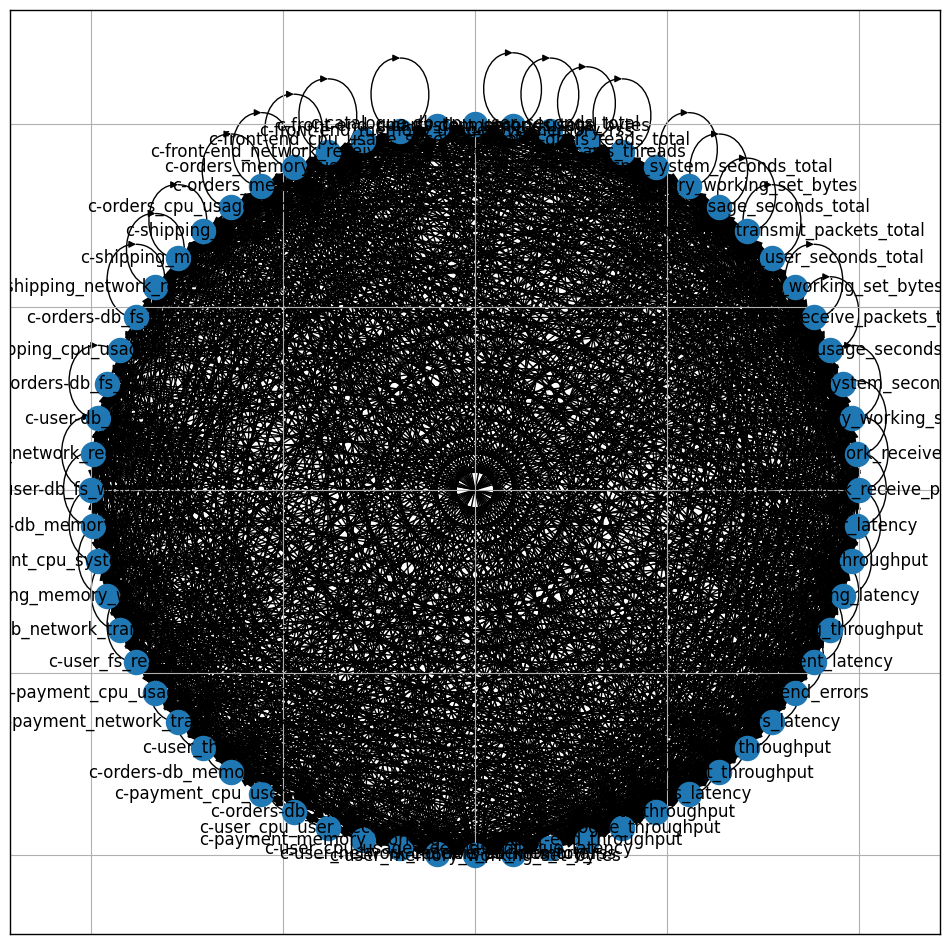

In [40]:
g = get_links(dataset_1, pcmci, pcmci_res, alpha_level = 0.001)
plt.figure(figsize=[12, 12])
nx.draw_networkx(g, pos=nx.circular_layout(g))

In [53]:
frontend = dataset_1.columns.tolist().index(frontend_sli_metric)
print(frontend)
# Q = get_Q_matrix(g, dataset_1, rho=0.2)
Q = get_Q_matrix_part_corr(g, dataset_1, rho=0.2)
vis_list = randomwalk(Q, 1000, frontend, teleportation_prob=0, walk_step=15)
gamma = get_gamma(dataset_1, vis_list, eta, lambda_param=lambda_param)
# prks, acc = evaluate(gamma)

51


KeyError: 51

In [57]:
pcmci, pcmci_res = run_lpcmci(dataset_1, pc_alpha = 0.10, verbosity=1)


Starting preliminary phase  1

Starting test phase

p = 0
(6,-4) independent (6, 0) given () union set()
(6,-3) independent (6, 0) given () union set()
(10,-3) independent (10, 0) given () union set()
(10,-2) independent (10, 0) given () union set()
(12,-4) independent (12, 0) given () union set()
(12,-3) independent (12, 0) given () union set()
(13,-4) independent (13, 0) given () union set()
(13,-3) independent (13, 0) given () union set()
(13,-2) independent (13, 0) given () union set()
(27,-4) independent (27, 0) given () union set()
(27,-3) independent (27, 0) given () union set()
(32,-3) independent (32, 0) given () union set()
(43,-4) independent (43, 0) given () union set()
(43,-3) independent (43, 0) given () union set()
(43,-2) independent (43, 0) given () union set()
(45,-2) independent (45, 0) given () union set()
(45,-1) independent (45, 0) given () union set()
(50,-4) independent (50, 0) given () union set()
Writing:   (6,-4) oL> (6, 0) ==> (6,-4)     (6, 0) 
Writing:   